## Analysis of a Stabilization graph
Based on J.S.-Y. Chao *et al.*, *J. Chem. Phys.* **93**, 1125 (1990)

See also M. F. Falcetta *et al.*, *J. Phys. Chem. A* **118**, 7489 (2014) 

Analytic continuation of two roots using a generalized Pade approximant and input data from a crossing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Qt5Agg')
#%matplotlib qt5

In [2]:
#
# if pade.py is not in the current directory, set this path:
#
import sys
sys.path.append('../../Python_libs')
import gen_pade as gpa
import stabtools as st

In [3]:
Angs2Bohr=1.8897259886
au2eV=27.211386027
au2cm=219474.63068
#
df=pd.read_csv("DVR_stab_plot.csv", delim_whitespace=False)
#df=pd.read_csv("GTO_unc_stab_plot.csv", delim_whitespace=False)
#df=pd.read_csv("GTO_DZ_stab_plot.csv", delim_whitespace=False)
#df=pd.read_csv("GTO_TZ_stab_plot.csv", delim_whitespace=False)
#
#df=pd.read_csv("/home/thomas/Current_Work/Caroline/Glyoxal/Stab/E_geo0.csv", delim_whitespace=True)
#df=pd.read_csv("/home/thomas/Current_Work/Caroline/Glyoxal/Stab/E_geo-1.csv", delim_whitespace=True)
#df=pd.read_csv("/home/thomas/Current_Work/Caroline/Glyoxal/Stab/Z_geo0_cleaned.csv")
#df=pd.read_csv("/home/thomas/Current_Work/Caroline/Glyoxal/Stab/Z_geo-1_cleaned.csv")

df.tail()

,L,z,E1,E2,E3,E4,E5,E6
116,0.641088,2.433128,-7.170508,1.578341,3.158979,4.734751,7.902352,11.477557
117,0.638897,2.449846,-7.170508,1.596348,3.163555,4.773552,7.957817,11.557290
118,0.636728,2.466564,-7.170508,1.614418,3.168079,4.812406,8.013206,11.637082
119,0.634581,2.483282,-7.170508,1.632548,3.172556,4.851303,8.068521,11.716934
120,0.632456,2.500000,-7.170508,1.650735,3.176994,4.890238,8.123765,11.796845


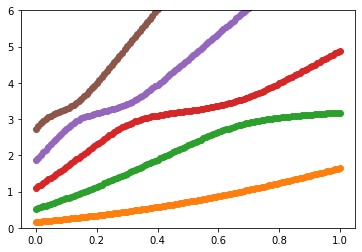

In [4]:
alpha=df.columns[1]
E_labels=df.columns[2:]
zs=df[alpha].values
zmin, zmax = zs[0], zs[-1]
if zmax < zmin:
    zmin, zmax = zmax, zmin
zs=(zs-zmin)/(zmax-zmin)
if True:
    plt.cla()
    for E in E_labels:
        plt.plot(zs, df[E].values, 'o-')
    plt.ylim(0,6)
    plt.show()

Set the following parameters after inspecting the stabilization plot:
* lroot: the lower root; the 2nd root is lroot+1
* curvature_drop-off: the crossing is defined by the minimum and maximum curvature positions; the  selection range is determined by the drop off of the abs(curvature) 

In [5]:
debug=False
if debug:
    lroot=2
    sth=1e-9
    curvature_drop_off=0.5
    E_lw=df[E_labels[lroot]].values
    E_up=df[E_labels[lroot+1]].values
    d1_lw, d2_lw = st.der_and_curvature(zs, E_lw, smooth=sth)
    d1_up, d2_up = st.der_and_curvature(zs, E_up, smooth=sth)
    j1_mn = np.argmin(d2_lw)
    j2_mx = np.argmax(d2_up)
    print(j1_mn, j2_mx)
    plt.cla()
    plt.plot(zs, d2_lw, zs, d2_up)
    plt.ylabel('curvature '+str(lroot)+' and '+str(lroot+1))
    plt.show()    

The auto-select may not work for *ab initio* data and broad crossings. 
* Check with the debug box above.
* Play with the smooth parameter.
* If all fails, use a range selected by-eye. 

Center of the crossing at z=0.308333
N = 15 points on each curve


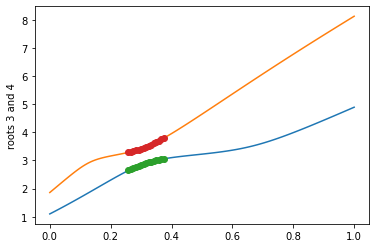

In [6]:
lroot=3
curvature_drop_off=0.5
E_lw=df[E_labels[lroot]].values
E_up=df[E_labels[lroot+1]].values
#success, zc, alps, E1s, E2s = st.crossing(zs, E_lw, E_up, select=-1)
success, zc, alps, E1s, E2s = st.crossing(zs, E_lw, E_up, select=curvature_drop_off)
npts = len(alps)
if not success or npts < 2:
    print('No crossing found. Try debug box above')
else:
    print('Center of the crossing at z=%f' % (zc))
    print('N = %d points on each curve' % (npts))
    plt.cla()
    plt.plot(zs, E_lw, zs, E_up)
    plt.plot(alps, E1s, 'o', alps, E2s, 'o')
    plt.ylabel('roots '+str(lroot)+' and '+str(lroot+1))
    plt.show()

In [7]:
by_hand=False
if by_hand:
    z_min=0.105
    z_max=0.35
    jmin=np.argmin(np.abs(zs-z_min))
    jmax=np.argmin(np.abs(zs-z_max))+1
    if jmax > len(zs):
        jmax = -1
    alps=zs[jmin:jmax]
    E1s=E_lw[jmin:jmax]
    E2s=E_up[jmin:jmax]
    print(f'{len(alps)} points on each curve')
    plt.cla()
    plt.plot(zs, E_lw, zs, E_up)
    plt.plot(alps, E1s, 'o', alps, E2s, 'o')
    plt.ylabel('roots '+str(lroot)+' and '+str(lroot+1))
    plt.show()    

Make one long list of all energies, which requires the L or alpha list twice,
to prepare the fit to a generalized Pade approximant.

In [8]:
LL = list(alps) + list(alps)
Es = list(E1s) + list(E2s)

## Fit to generalized [$n$,$n$,$n$]-Pade approximant.

P*E^2 + Q*E + R = 0
P :
         2
1.679 x - 0.4627 x + 0.1167

Q :
          3         2
-14.07 x - 2.162 x + 0.6701 x - 0.4335

R :
         4         3         2
12.01 x + 31.53 x - 4.334 x + 1.277 x + 0.3103


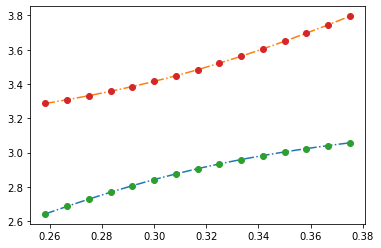

In [9]:
nP, nQ, nR = 2, 3, 4
A, B, C = gpa.genpade2_via_lstsq(nP, nQ, nR, LL, Es, rcond=1e-14)
print('P*E^2 + Q*E + R = 0')
print('P :\n ', A)
print('\nQ :\n ', B)
print('\nR :\n ', C)

#
# compare the input energies and the fitted curves
#
npts=100
Lplots=np.linspace(LL[0],LL[-1],npts)
E1plot=np.zeros(npts)
E2plot=np.zeros(npts)
for i in range(npts):
    E1plot[i]=gpa.E_lower(Lplots[i], A, B, C)
    E2plot[i]=gpa.E_upper(Lplots[i], A, B, C)
plt.cla()
plt.plot(Lplots,E1plot,'-.')
plt.plot(Lplots,E2plot,'-.')
plt.plot(alps,E1s,'o')
plt.plot(alps,E2s,'o')

### Evaluate the Pade approximant in the complex plane. 
* That gives two roots. 
* Plot log(|dE/dL|) for the lower (or for both) 

In [41]:
npts=48
s=1
center=(alps[-1]+alps[0])/2
half_d=(alps[-1]-alps[0])/2
re1=center - (1+s)*half_d
re2=center + (1+s)*half_d
im1=-4*half_d
im2=0
Res=np.linspace(re1,re2,npts) 
Ims=np.linspace(im1,im2,npts)
der1 = np.zeros([npts,npts])
der2 = np.zeros([npts,npts])
for r in range(npts):
    for i in range(npts):
        z = Res[r] + 1j*Ims[i]
        rs, ds = gpa.E_and_Ep(z, A, B, C)
        der1[i,r] = np.log10(min(ds))
        #der2[i,r] = np.log10(max(ds))

plt.cla()        
#plt.figure(1)
plt.contourf(Res, Ims, der1, 10, cmap=plt.cm.jet_r)
plt.colorbar()
#plt.figure(2)
#plt.contourf(Res, Ims, der2, 10, cmap=plt.cm.jet_r)
#plt.colorbar()
plt.show()

### Establish a list of stationary points.

* Start Newton on an N-by-N search grid.
* Do at most 10 steps discarding unconverged runs.
* Drop any duplicates.

In [46]:
Econv = []
Lconv = []
npts = 10
Res=np.linspace(re1,re2,npts) 
Ims=np.linspace(im1,im2,npts)
for r in range(npts):
    for i in range(npts):
        z_guess = Res[r] + 1j*Ims[i]
        conv, Lstar, Estar, der = gpa.GPA_NewtonRaphson(z_guess, (A, B, C), max_step=10, verbose=False)
        if conv:
            Econv.append(Estar)
            Lconv.append(Lstar)

Econv = np.array(Econv)
Lconv = np.array(Lconv)
df=pd.DataFrame({"Er": Econv.real, "Ei": Econv.imag, "Lr": Lconv.real, "Li": Lconv.imag})
df['Er6dig']=np.round(df['Er'],6)
df['Ei6dig']=np.round(df['Ei'],6)
df.drop_duplicates(subset=['Er6dig', 'Ei6dig'], inplace=True)
pattern=((df['Li']<0) & (df['Lr']>0))
df[pattern].sort_values(by=['Lr'])

,Er,Ei,Lr,Li,Er6dig,Ei6dig
2,3.199801,-0.161587,0.237439,-0.119341,3.199801,-0.161587
0,3.148585,-0.161590,0.345780,-0.168395,3.148585,-0.161590


In [47]:
df[pattern].describe()

,Er,Ei,Lr,Li,Er6dig,Ei6dig
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,3.174193,-0.161588,0.291610,-0.143868,3.174193,-0.161589
std,0.036215,0.000002,0.076609,0.034686,0.036215,0.000002
min,3.148585,-0.161590,0.237439,-0.168395,3.148585,-0.161590
25%,3.161389,-0.161589,0.264524,-0.156131,3.161389,-0.161589
50%,3.174193,-0.161588,0.291610,-0.143868,3.174193,-0.161589
75%,3.186997,-0.161588,0.318695,-0.131604,3.186997,-0.161588
max,3.199801,-0.161587,0.345780,-0.119341,3.199801,-0.161587


Identify and optimize roots by hand

In [23]:
#
#   read-off minima from figure 1
#
L_guess=0.34-1j*0.15

roots, ders = gpa.E_and_Ep(L_guess, A, B, C)
for i, r in enumerate(roots):
    print('(%f, %f)  d=%f' % (r.real, r.imag, ders[i]))
i_root=np.argmin(ders)
Ecurr=roots[i_root]
step = gpa.EpoEpp(Ecurr, L_guess, A, B, C)
print('Newton step for root %d: (%f, %f)' % (i_root, step.real, step.imag))

(3.404677, -1.022421)  d=8.100316
(3.147459, -0.163520)  d=0.242815
Newton step for root 1: (-0.005239, 0.015873)


In [24]:
conv, Lstar, Estar, der = gpa.GPA_NewtonRaphson(L_guess, (A, B, C))
if conv:
    print("  L_star = (%.6f, %.6f)" % (Lstar.real, Lstar.imag))
    print('  derivative = %.3e' % (der))
    print("  Er = %.6f,  Ei = %.6f" % (Estar.real, Estar.imag))
else:
    print("No convergence in 20 steps.")

Newton Raphson steps:
 step    z_curr                   E_curr
-----------------------------------------------------
  0   (0.3452387, -0.1658729)   (3.1485616, -0.1616183)
  1   (0.3457857, -0.1683543)   (3.1485855, -0.1615899)
  2   (0.3457805, -0.1683946)   (3.1485855, -0.1615899)
  3   (0.3457805, -0.1683946)   (3.1485855, -0.1615899)
  L_star = (0.345780, -0.168395)
  derivative = 7.503e-14
  Er = 3.148585,  Ei = -0.161590
